In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
import tensorflow as tf
from collections import deque

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
dataset_path = "C:/Users/batuh/Downloads/Compressed/Dataset"
actions = os.listdir(dataset_path)

In [3]:
frame_count = 20

frame_width = 64
frame_height = 64

seed_constant = 86
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
def take_video_names(dataset_path):

  actions = os.listdir(dataset_path)
  video_paths = []
  video_labels = []

  for single_action in actions:

    videos = os.listdir(dataset_path + "/" + single_action)

    for single_video in videos:

      single_video_path = dataset_path + "/" + single_action + "/" + single_video

      video_paths.append(single_video_path)
      video_labels.append(single_action)

  print(f"There is {len(actions)} action in the dataset.")
  print(f"There is {len(video_paths)} video in the dataset\n")

  return np.array(video_paths), np.array(video_labels)

In [5]:
def video_preprocess(frame):

  resized_frame = cv2.resize(frame, (frame_height, frame_width))

  normalized_frame = resized_frame / 255

  return normalized_frame

In [6]:
def load_video (video_path):

  frames_list = []

  cap = cv2.VideoCapture(video_path)

  ok, frame = cap.read()

  video_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  skip_ratio = max(int(video_frame_count/frame_count), 1)

  for i in range(frame_count):

    cap.set(cv2.CAP_PROP_POS_FRAMES, i * skip_ratio)

    oke, frame = cap.read()

    if not oke:
      break

    frame = video_preprocess(frame)

    frames_list.append(frame)

  if len(frames_list) != frame_count:
    print(f"There is not enough number of frames in this video {video_path}")

  cap.release()

  return frames_list

In [7]:
feature_s = []

count = 0

videos, labels = take_video_names(dataset_path)

for one_video in videos:

  count = count + 1

  feature_s.append(load_video(one_video))

  print (f"{count/len(videos)*100} percent complete ")

feature_s = np.array(feature_s)

There is 4 action in the dataset.
There is 850 video in the dataset

0.1176470588235294 percent complete 
0.2352941176470588 percent complete 
0.35294117647058826 percent complete 
0.4705882352941176 percent complete 
0.5882352941176471 percent complete 
0.7058823529411765 percent complete 
0.823529411764706 percent complete 
0.9411764705882352 percent complete 
1.0588235294117647 percent complete 
1.1764705882352942 percent complete 
1.2941176470588236 percent complete 
1.411764705882353 percent complete 
1.5294117647058825 percent complete 
1.647058823529412 percent complete 
1.7647058823529411 percent complete 
1.8823529411764703 percent complete 
2.0 percent complete 
2.1176470588235294 percent complete 
2.235294117647059 percent complete 
2.3529411764705883 percent complete 
2.4705882352941173 percent complete 
2.588235294117647 percent complete 
2.705882352941176 percent complete 
2.823529411764706 percent complete 
2.941176470588235 percent complete 
3.058823529411765 percent co

In [8]:
print(len(feature_s))
print(type(feature_s))

850
<class 'numpy.ndarray'>


In [9]:
le = LabelEncoder()
labels = le.fit_transform(labels)

one_hot_encoded_labels = to_categorical(labels)

In [10]:
features_train, features_test, labels_train, labels_test = train_test_split(feature_s, 
                                                                            one_hot_encoded_labels, 
                                                                            test_size = 0.25, 
                                                                            shuffle = True, 
                                                                            random_state = seed_constant)

In [11]:
del feature_s
del labels
del count

In [12]:
def create_LRCN_model():

    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (frame_count, frame_height, frame_width, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(actions), activation = 'softmax'))


    model.summary()
    
    return model

In [13]:
LRCN_model = create_LRCN_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 64, 64, 64)    1792      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 16, 16, 64)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 16, 16, 64)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 16, 16, 64)    36928     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 4, 4, 64)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 4, 4, 64)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 4, 4, 32)      1

In [14]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 60, mode = 'min', restore_best_weights = True)

LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, 
                                             callbacks = [early_stopping_callback])

Epoch 1/70
128/128 [==============================] - 7s 22ms/step - loss: 1.3919 - accuracy: 0.2574 - val_loss: 1.3817 - val_accuracy: 0.2734
Epoch 2/70
128/128 [==============================] - 2s 17ms/step - loss: 1.3861 - accuracy: 0.2770 - val_loss: 1.3814 - val_accuracy: 0.2734
Epoch 3/70
128/128 [==============================] - 2s 16ms/step - loss: 1.3863 - accuracy: 0.2750 - val_loss: 1.3816 - val_accuracy: 0.2734
Epoch 4/70
128/128 [==============================] - 2s 16ms/step - loss: 1.3870 - accuracy: 0.2770 - val_loss: 1.3820 - val_accuracy: 0.2734
Epoch 5/70
128/128 [==============================] - 2s 16ms/step - loss: 1.3855 - accuracy: 0.2750 - val_loss: 1.3798 - val_accuracy: 0.2734
Epoch 6/70
128/128 [==============================] - 2s 17ms/step - loss: 1.3836 - accuracy: 0.2849 - val_loss: 1.3661 - val_accuracy: 0.2969
Epoch 7/70
128/128 [==============================] - 2s 16ms/step - loss: 1.4009 - accuracy: 0.2593 - val_loss: 1.3822 - val_accuracy: 0.2734

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


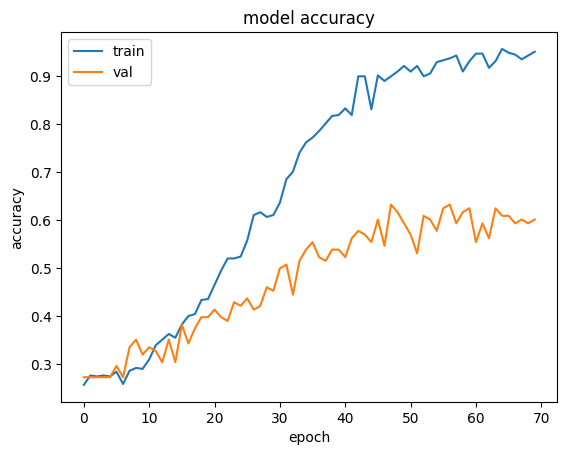

In [15]:
print(LRCN_model_training_history.history.keys())
plt.plot(LRCN_model_training_history.history['accuracy'])
plt.plot(LRCN_model_training_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

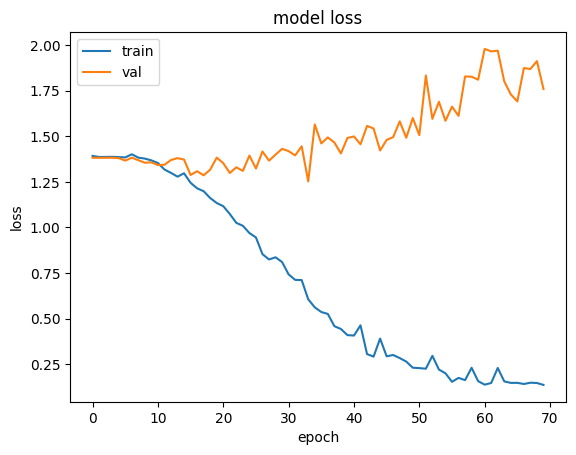

In [16]:
plt.plot(LRCN_model_training_history.history['loss'])
plt.plot(LRCN_model_training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

7/7 [==============================] - 1s 56ms/step - loss: 1.6342 - accuracy: 0.6197


In [18]:
# del LRCN_model

In [35]:
Y_test = np.argmax(labels_test, axis=1) # Convert one-hot to index
y_pred = np.argmax(LRCN_model.predict(features_test), axis=-1)
print(classification_report(Y_test, y_pred))

print('\n')
print(actions[3])

              precision    recall  f1-score   support

           0       0.73      0.67      0.70        54
           1       0.65      0.57      0.61        60
           2       0.58      0.67      0.62        58
           3       0.51      0.56      0.53        41

    accuracy                           0.62       213
   macro avg       0.62      0.62      0.62       213
weighted avg       0.63      0.62      0.62       213



wave


In [28]:
def predict_on_camera():

    cam = cv2.VideoCapture(0)
    
    cam_frame_list = deque(maxlen = frame_count)

    while True:

        ok, cam_frame = cam.read()
    
        if ok == True:
        
            normalized_cam_frame = video_preprocess(cam_frame)

            cam_frame_list.append(normalized_cam_frame)

        if len(cam_frame_list) == 20:

            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(cam_frame_list, axis = 0))[0]
            
            for i in range(len(actions)):
                
                if predicted_labels_probabilities[i] > 0.95 and predicted_labels_probabilities[i] < 1.0:
                    
                    predicted_label = np.argmax(predicted_labels_probabilities)

                    predicted_class_name = actions[predicted_label]

                    cv2.putText(cam_frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
        cv2.imshow("Frame", cam_frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    cam.release()

In [26]:
while True:
    
    predict_on_camera()

Exception ignored in: <function ScopedTFFunction.__del__ at 0x000001934239D550>
Traceback (most recent call last):
  File "c:\Users\batuh\anaconda3\envs\action\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 110, in __del__
    self.deleter(self.func)
KeyboardInterrupt: 


KeyboardInterrupt: 